# Global Shark Foraging Habitat Prediction Heatmap

This notebook demonstrates the application of a machine learning model to predict shark foraging habitats worldwide using satellite ocean data. The model uses various oceanographic parameters to generate probability maps of foraging activity.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import joblib
import os
from glob import glob

In [17]:
# Load the trained model and preprocessing objects
model = joblib.load('foraging_habitat_model_intensive.pkl')  # Use the intensive model trained on polynomial features
scaler = joblib.load('scaler_intensive.pkl')
poly = joblib.load('poly_features.pkl')

print("Model and preprocessing objects loaded successfully!")

Model and preprocessing objects loaded successfully!


In [8]:
print(f"Poly n_features_in_: {poly.n_features_in_}")
print(f"Poly n_output_features_: {poly.n_output_features_}")
print(f"Scaler n_features_in_: {scaler.n_features_in_}")
print(f"Poly include_bias: {poly.include_bias}")
print(f"Poly interaction_only: {poly.interaction_only}")
print(f"Poly degree: {poly.degree}")

Poly n_features_in_: 8
Poly n_output_features_: 36
Scaler n_features_in_: 39
Poly include_bias: False
Poly interaction_only: True
Poly degree: 2


In [14]:
print(f"Model type: {type(model)}")
print(f"Model: {model}")

Model type: <class 'sklearn.ensemble._voting.VotingClassifier'>
Model: VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss'...
                                            grow_policy=None,
                       

In [4]:
# Define the date range for the showcase (using one 8-day composite)
date_range = "20090618_20090625"

# Define the variable mappings
var_folders = {
    'chl': 'chl_binned',
    'nflh': 'flh_binned',
    'a_412': 'iop_binned',
    'bb_412': 'iop_binned',
    'kd_490': 'kd_binned',
    'pic': 'pic_binned',
    'rrs_412': 'rrs_binned',
    'sst': 'sst_binned'
}

# Variable names in the NetCDF files
var_names = {
    'chl': 'chlor_a',
    'nflh': 'nflh',
    'a_412': 'a_412',
    'bb_412': 'bb_412',
    'kd_490': 'Kd_490',
    'pic': 'pic',
    'rrs_412': 'Rrs_412',
    'sst': 'sst'
}

# Load all datasets
datasets = {}
for var, folder in var_folders.items():
    pattern = f"descargas/{folder}/AQUA_MODIS.{date_range}.L3m.8D.*.{var_names[var]}.9km.nc"
    files = glob(pattern)
    if files:
        ds = xr.open_dataset(files[0])
        datasets[var] = ds[var_names[var]]
        print(f"Loaded {var} from {files[0]}")
    else:
        print(f"Warning: No file found for {var}")

print(f"Loaded {len(datasets)} variables")

Loaded chl from descargas/chl_binned\AQUA_MODIS.20090618_20090625.L3m.8D.CHL.chlor_a.9km.nc
Loaded nflh from descargas/flh_binned\AQUA_MODIS.20090618_20090625.L3m.8D.FLH.nflh.9km.nc
Loaded a_412 from descargas/iop_binned\AQUA_MODIS.20090618_20090625.L3m.8D.IOP.a_412.9km.nc
Loaded bb_412 from descargas/iop_binned\AQUA_MODIS.20090618_20090625.L3m.8D.IOP.bb_412.9km.nc
Loaded kd_490 from descargas/kd_binned\AQUA_MODIS.20090618_20090625.L3m.8D.KD.Kd_490.9km.nc
Loaded pic from descargas/pic_binned\AQUA_MODIS.20090618_20090625.L3m.8D.PIC.pic.9km.nc
Loaded rrs_412 from descargas/rrs_binned\AQUA_MODIS.20090618_20090625.L3m.8D.RRS.Rrs_412.9km.nc
Loaded sst from descargas/sst_binned\AQUA_MODIS.20090618_20090625.L3m.8D.SST.sst.9km.nc
Loaded 8 variables
Loaded kd_490 from descargas/kd_binned\AQUA_MODIS.20090618_20090625.L3m.8D.KD.Kd_490.9km.nc
Loaded pic from descargas/pic_binned\AQUA_MODIS.20090618_20090625.L3m.8D.PIC.pic.9km.nc
Loaded rrs_412 from descargas/rrs_binned\AQUA_MODIS.20090618_20090625

In [5]:
# Get coordinates from one dataset (assuming all have same grid)
sample_ds = list(datasets.values())[0]
lat = sample_ds.lat.values
lon = sample_ds.lon.values

# Create meshgrid for all lat/lon combinations
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Flatten the grids
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()

# Create dataframe for features
features_df = pd.DataFrame({
    'location-lat': lat_flat,
    'location-long': lon_flat
})

# Add each variable
for var in ['nflh', 'chl', 'a_412', 'bb_412', 'pic', 'kd_490', 'rrs_412', 'sst']:
    if var in datasets:
        data_flat = datasets[var].values.flatten()
        features_df[var] = data_flat
    else:
        print(f"Warning: {var} not found, filling with NaN")
        features_df[var] = np.nan

print(f"Created features dataframe with shape: {features_df.shape}")
print(features_df.head())

Created features dataframe with shape: (9331200, 10)
   location-lat  location-long  nflh  chl  a_412  bb_412  pic  kd_490  \
0     89.958336    -179.958328   NaN  NaN    NaN     NaN  NaN     NaN   
1     89.958336    -179.875000   NaN  NaN    NaN     NaN  NaN     NaN   
2     89.958336    -179.791672   NaN  NaN    NaN     NaN  NaN     NaN   
3     89.958336    -179.708328   NaN  NaN    NaN     NaN  NaN     NaN   
4     89.958336    -179.625000   NaN  NaN    NaN     NaN  NaN     NaN   

   rrs_412  sst  
0      NaN  NaN  
1      NaN  NaN  
2      NaN  NaN  
3      NaN  NaN  
4      NaN  NaN  


In [15]:
# Handle missing values (fill with median or appropriate values)
# For ocean data, we can fill NaN with a reasonable default or interpolate
# But for simplicity, let's drop rows with NaN for now
features_clean = features_df.dropna()

print(f"After dropping NaN: {features_clean.shape}")

# Extract features for model
X = features_clean[['nflh', 'chl', 'a_412', 'bb_412', 'pic', 'kd_490', 'rrs_412', 'sst']]

# Apply polynomial features
X_poly = poly.transform(X)
print(f"X_poly shape: {X_poly.shape}")

# Pad X_poly to match scaler input (39 features)
if X_poly.shape[1] < scaler.n_features_in_:
    padding = np.zeros((X_poly.shape[0], scaler.n_features_in_ - X_poly.shape[1]))
    X_poly_padded = np.hstack([X_poly, padding])
else:
    X_poly_padded = X_poly

# Apply scaling
X_scaled = scaler.transform(X_poly_padded)

print(f"Preprocessed data shape: {X_scaled.shape}")

After dropping NaN: (2726639, 10)
X_poly shape: (2726639, 36)
X_poly shape: (2726639, 36)


C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Preprocessed data shape: (2726639, 39)


In [18]:
# Predict foraging habitat probabilities
probabilities = model.predict_proba(X_scaled)[:, 1]  # Probability of positive class (foraging)

# Add probabilities back to the dataframe
features_clean['foraging_probability'] = probabilities

print(f"Predictions completed. Probability range: {probabilities.min():.4f} - {probabilities.max():.4f}")
print(f"Mean probability: {probabilities.mean():.4f}")

C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid f

Predictions completed. Probability range: 0.2761 - 0.6256
Mean probability: 0.4949


C:\Users\chuca\AppData\Local\Temp\ipykernel_9724\3208782930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean['foraging_probability'] = probabilities


In [19]:
# Create a full grid for plotting (including land/NaN areas)
prob_grid = np.full(lat_grid.shape, np.nan)

# Get indices of valid data points
valid_indices = features_clean.index

# Fill the grid with predictions
for idx in valid_indices:
    lat_idx = np.where(lat == features_clean.loc[idx, 'location-lat'])[0][0]
    lon_idx = np.where(lon == features_clean.loc[idx, 'location-long'])[0][0]
    prob_grid[lat_idx, lon_idx] = features_clean.loc[idx, 'foraging_probability']

print(f"Created probability grid with shape: {prob_grid.shape}")

Created probability grid with shape: (2160, 4320)


c:\Users\chuca\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\chuca\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\chuca\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\chuca\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloa

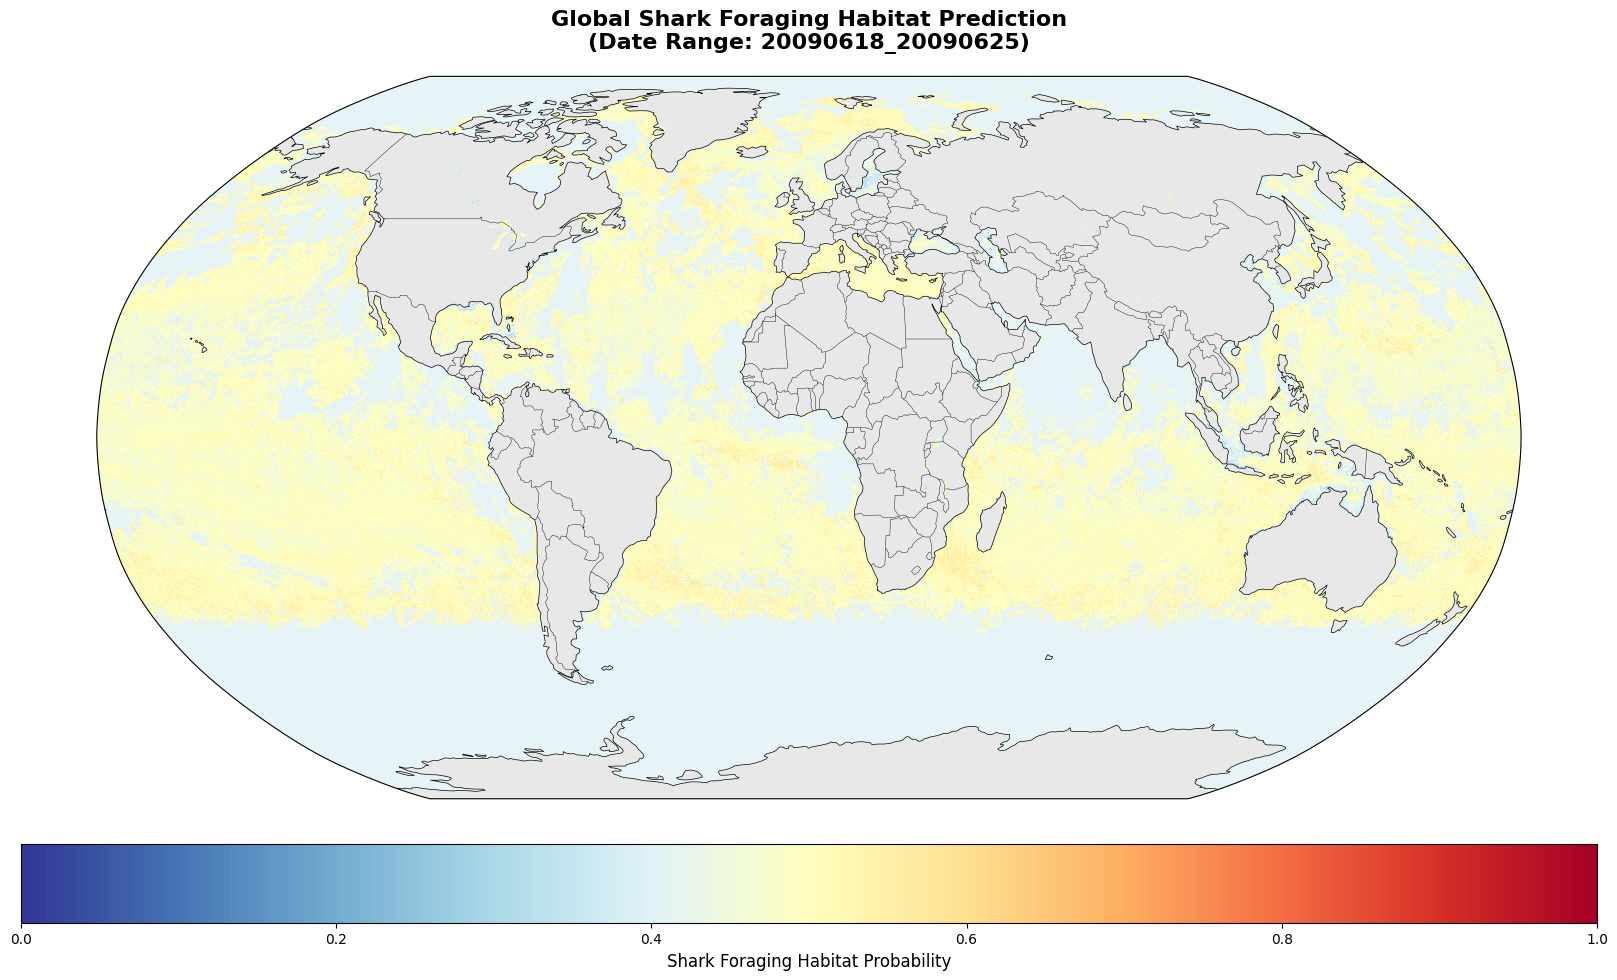

In [20]:
# Create the heatmap on world map
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Robinson())

# Add features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Plot the probability heatmap
mesh = ax.pcolormesh(lon_grid, lat_grid, prob_grid, 
                     transform=ccrs.PlateCarree(), 
                     cmap='RdYlBu_r', 
                     vmin=0, vmax=1, 
                     shading='auto')

# Add colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Shark Foraging Habitat Probability', fontsize=12)

# Add title
plt.title(f'Global Shark Foraging Habitat Prediction\n(Date Range: {date_range})', 
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()

In [21]:
# Save the figure as PNG
output_filename = f'shark_foraging_heatmap_{date_range}.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"Heatmap saved as {output_filename}")

# Show the plot
plt.show()

Heatmap saved as shark_foraging_heatmap_20090618_20090625.png


<Figure size 640x480 with 0 Axes>